In [0]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
from __future__ import print_function
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
#from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
import numpy as np
import os

In [0]:

# Training parameters

num_classes = 10

# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True


In [0]:

# Model parameter

# ResNet14   n=2
# ResNet20   n=3 
# ResNet32   n=5     
n = 1 #3

# Model version
version = 1

# Computed depth from supplied model parameter n
depth = n * 6 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)


In [0]:
# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()


In [0]:
y_train

array([[6],
       [9],
       [9],
       ...,
       [9],
       [1],
       [1]], dtype=uint8)

In [0]:
x_train.shape

(50000, 32, 32, 3)

In [0]:
# Input image dimensions.
input_shape = x_train.shape[1:]   # (32,32,3) <- (?, 32,32,3)

# Normalize data.
x_train, x_test = x_train/255., x_test/255.

# If subtract pixel mean is enabled ???
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [0]:
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

##  2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
  

In [0]:

def resnet_layer(inputs,num_filters=16,kernel_size=3,strides=1,
                 activation='relu',batch_normalization=True,conv_first=True):
 
    conv = Conv2D(num_filters, kernel_size=kernel_size,
                  strides=strides, padding='same',kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:          # conv first
        x = conv(x)
        if batch_normalization :
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:                   # activation first
        if batch_normalization :
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

## ResNet Version 1 Model builder



    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
  

In [0]:
def resnet_v1(input_shape, depth, num_classes=10):
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)           # first resnet
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,num_filters=num_filters,strides=strides)
            y = resnet_layer(inputs=y,num_filters=num_filters,activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,num_filters=num_filters,kernel_size=1,
                                 strides=strides,activation=None,batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


In [0]:

model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()
print(model_type)


Learning rate:  0.001
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization[0][0]        
________________________________________________________________________

In [0]:

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)


In [0]:

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_acc',
                             verbose=1, save_best_only=True)


In [0]:

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0,
                               patience=5, min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]


Learning rate:  0.001  
Epoch 50/50  
49920/50000 [============================>.] - ETA: 0s - loss: 0.3577 - accuracy: 0.9272WARNING:tensorflow:Can save best model only with val_acc available, skipping.  
50000/50000 [==============================] - 25s 496us/sample - loss: 0.3576 - accuracy: 0.9272 - val_loss: 1.1700 - val_accuracy: 0.7350  
Test loss: 1.170027961730957  
Test accuracy: 0.735

In [0]:
%%time
batch_size = 128  # orig paper trained all networks with batch_size=128
epochs = 10  # 50
# Run training, with or without data augmentation.
data_augmentation = False

if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs,
                  validation_data=(x_test, y_test), shuffle=True,
                  callbacks=callbacks)
    # Score trained model.
    scores = model.evaluate(x_test, y_test, verbose=1)
    print('Test loss:', scores[0])
    print('Test accuracy:', scores[1])

Not using data augmentation.
Train on 50000 samples, validate on 10000 samples
Learning rate:  0.001
Epoch 1/10
50000/50000 [==============================] - 17s 339us/sample - loss: 1.5873 - accuracy: 0.4460 - val_loss: 1.5028 - val_accuracy: 0.4759
Learning rate:  0.001
Epoch 2/10
50000/50000 [==============================] - 13s 256us/sample - loss: 1.2388 - accuracy: 0.5784 - val_loss: 1.5355 - val_accuracy: 0.5062
Learning rate:  0.001
Epoch 3/10
50000/50000 [==============================] - 13s 255us/sample - loss: 1.0901 - accuracy: 0.6351 - val_loss: 1.2363 - val_accuracy: 0.5863
Learning rate:  0.001
Epoch 4/10
50000/50000 [==============================] - 13s 255us/sample - loss: 0.9956 - accuracy: 0.6710 - val_loss: 1.2203 - val_accuracy: 0.5753
Learning rate:  0.001
Epoch 5/10
50000/50000 [==============================] - 13s 256us/sample - loss: 0.9212 - accuracy: 0.6983 - val_loss: 1.2343 - val_accuracy: 0.6017
Learning rate:  0.001
Epoch 6/10
50000/50000 [==========

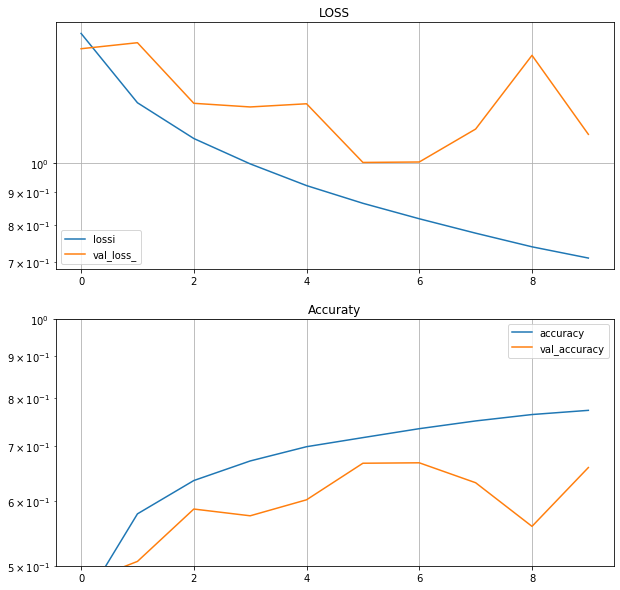

In [0]:
import matplotlib.pyplot as plt

losses = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.semilogy(losses, label='lossi')
plt.semilogy(val_loss, label='val_loss_')
plt.grid(True)
plt.legend(loc='best')
plt.title("LOSS")

plt.subplot(2, 1, 2)
plt.ylim(0.5,1)
plt.semilogy(acc, label='accuracy')
plt.semilogy(val_acc, label='val_accuracy')
plt.grid(True)
plt.legend(loc='best')
plt.title("Accuraty")
plt.show()  


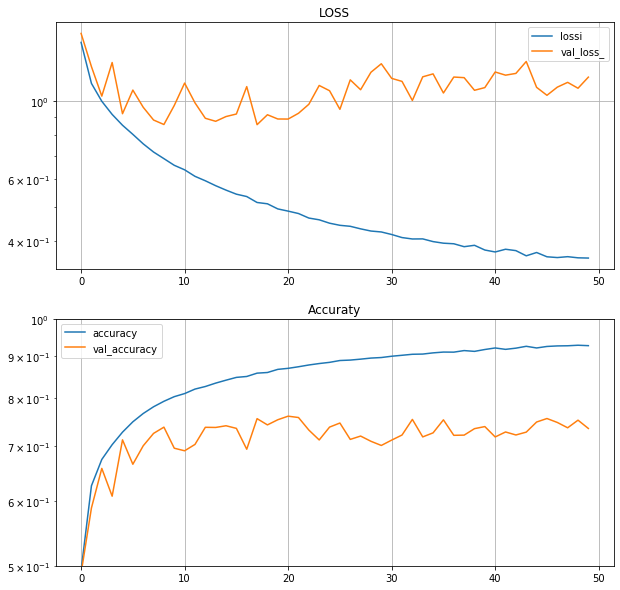

## 실습 과제
### 1. 실행 시간을 줄이기 위해 ResNet-8 로 설정되어 있다
####  - 레이어를 늘려서 #P와 학습 시간의 관계를 확인하자 
#####    - ResNet-8, ResNet-14, ResNet-20 에서 #P는 얼마인가?
#####    - epoch 10까지만 수행해 보고 #P와 학습 시간의 관계를 개략적으로 계산해 보자 

### 2. ResNet-8 학습을 overfitting이 발생하는지 확인해 보자 
#### Data Augmentation을 시도해 보자, 더 좋아 지는가?

In [0]:
# Run training, with or without data augmentation.
data_augmentation = True

if data_augmentation:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.,
        # set range for random channel shifts
        channel_shift_range=0.,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1, workers=4,
                        callbacks=callbacks)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Using real-time data augmentation.
Learning rate:  0.001
Epoch 1/10
390/391 [============================>.] - ETA: 0s - loss: 0.8943 - accuracy: 0.7104

RuntimeError: ignored